### 590 HW3

#### Author: Siyao Peng    




     

In [90]:
from keras import backend as K
from keras.applications import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Conv1D, Conv2D, MaxPooling2D, UpSampling2D, Dropout, MaxPooling1D
from keras.layers import LSTM, Embedding
from keras.optimizers import RMSprop

from keras.utils import np_utils
from keras.callbacks import EarlyStopping  
from keras.datasets import fashion_mnist

from sklearn.metrics import roc_curve

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


### 1. Autoencoder

When input data consists of images, it is a good idea to use a convolutional autoencoder. It is not an autoencoder variant, but rather a traditional autoencoder stacked with convolution layers: basically replace fully connected layers by convolutional layers. Convolution layers along with max-pooling layers, convert the input from wide (a 28 x 28 image) and thin (a single channel or gray scale) to small (7 x 7 image at the latent space) and thick (128 channels).

Let's prepare our input data. We're using fashion MNIST images, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# data normalization
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)

(60000, 28, 28)


In [3]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


The encoder will consist of a stack of Conv2D and MaxPooling2D layers, while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [4]:
# this is our input placeholder
input_img = Input(shape=(28, 28, 1))  

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)   
x = MaxPooling2D((2, 2), padding='same')(x)    
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)  
x = MaxPooling2D((2, 2), padding='same')(x)   
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)    
x = MaxPooling2D((2, 2), padding='same')(x)     
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)    
encoded = MaxPooling2D((2, 2), padding='same')(x)     

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [5]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 16)          0   

In [6]:
from keras.callbacks import EarlyStopping  

eary_stopping = EarlyStopping(  # halt training when loss stops decreasing, very useful when #epochs is large
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

autoencoder_history = autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[eary_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 82s 1ms/step - loss: 0.3953 - val_loss: 0.3379
Epoch 2/20
60000/60000 [==============================] - 81s 1ms/step - loss: 0.3370 - val_loss: 0.3261
Epoch 3/20
60000/60000 [==============================] - 73s 1ms/step - loss: 0.3258 - val_loss: 0.3221
Epoch 4/20
60000/60000 [==============================] - 71s 1ms/step - loss: 0.3195 - val_loss: 0.3218
Epoch 5/20
60000/60000 [==============================] - 72s 1ms/step - loss: 0.3163 - val_loss: 0.3159
Epoch 6/20
60000/60000 [==============================] - 72s 1ms/step - loss: 0.3134 - val_loss: 0.3138
Epoch 7/20
60000/60000 [==============================] - 96s 2ms/step - loss: 0.3112 - val_loss: 0.3127
Epoch 8/20
60000/60000 [==============================] - 72s 1ms/step - loss: 0.3090 - val_loss: 0.3090
Epoch 9/20
60000/60000 [==============================] - 74s 1ms/step - loss: 0.3074 - val_loss: 0.3089
Epoch

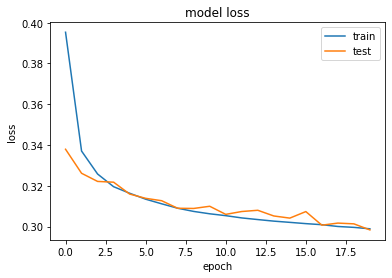

In [7]:
# Evaluate
def plot_train_history_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot_train_history_loss(autoencoder_history)

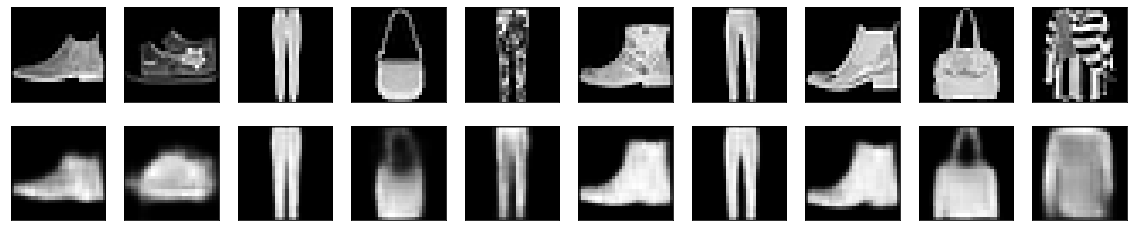

In [8]:
# Display original and reconstruction Images
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[-i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    if decoded_imgs is not None:
        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[-i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

### 2. Image Classification

#### (1) Deep CNN

In [9]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [10]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(60000, 28, 28, 1) (60000, 10)
(10000, 28, 28, 1) (10000, 10)


In [11]:
Y_test[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [12]:
model = Sequential()
model.add(Conv2D(filters = 32,kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='valid',
                 input_shape=(28,28,1)))

model.add(Conv2D(filters = 50,kernel_size=(3, 3), 
                 activation='relu', strides=(2, 2), 
                 padding='valid'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 50,kernel_size=(3, 3), 
                 activation='relu', strides=(2, 2), 
                 padding='valid'))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 20,kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 50)        14450     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 50)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 2, 2, 50)          22550     
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 50)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 2, 2, 20)          9020      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 20)         

First, convolve over 32 kernels whose size is 3 by 3, the stride is 1, so move one step every time, there is no padding, after this step, the layer shape becomes 26 by 26 by 32.    

Second, convolve over 50 kernels whose size is 3 by 3, the stride is 2, so move two steps every time, there is no padding, after this step, the layer shape becomes 12 by 12 by 50.     

Then, we downsample by maxpooling over 2 by 2 filter, after this step, the layer shape is 6 by 6 by 50.   

In the fourth step, convolve over 50 kernels whose size is 3 by 3, the stride is 2, so move two steps every time, there is no padding, after this step, the layer shape becomes 2 by 2 by 50. 

In the fifth step, convolve over 20 kernels whose size is 3 by 3, the stride is 1, so move one step every time, there is no padding, after this step, the layer shape becomes 1 by 1 by 20.   

Next, we downsample by maxpooling over 2 by 2 filter, after this step, the layer shape is 1 by 1 by 20.      
  
Then, flatten the layer, and build two fully connected layers and output the result.    

There are 8 layers in total. 


In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
eary_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

deep_cnn = model.fit(X_train,
                     Y_train,
                     batch_size=128,
                     epochs=20,
                     validation_data=(X_test, Y_test),
                     callbacks= [eary_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 30s 493us/step - loss: 0.9478 - accuracy: 0.6590 - val_loss: 0.5426 - val_accuracy: 0.8015
Epoch 2/20
60000/60000 [==============================] - 26s 432us/step - loss: 0.5729 - accuracy: 0.7972 - val_loss: 0.4484 - val_accuracy: 0.8336
Epoch 3/20
60000/60000 [==============================] - 26s 431us/step - loss: 0.5013 - accuracy: 0.8228 - val_loss: 0.4161 - val_accuracy: 0.8425
Epoch 4/20
60000/60000 [==============================] - 26s 439us/step - loss: 0.4619 - accuracy: 0.8370 - val_loss: 0.3868 - val_accuracy: 0.8566
Epoch 5/20
60000/60000 [==============================] - 26s 434us/step - loss: 0.4302 - accuracy: 0.8482 - val_loss: 0.3742 - val_accuracy: 0.8596
Epoch 6/20
60000/60000 [==============================] - 26s 435us/step - loss: 0.4095 - accuracy: 0.8567 - val_loss: 0.3461 - val_accuracy: 0.8732
Epoch 7/20
60000/60000 [==============================] 

In [16]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('test score:', score)

10000/10000 [==============================] - 1s 136us/step
test score: [0.2916094063639641, 0.8980000019073486]


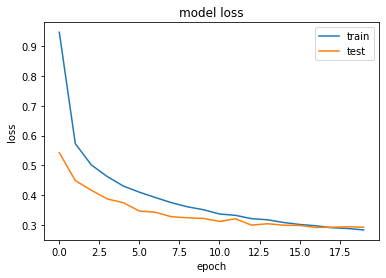

In [17]:
def plot_train_history_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot_train_history_loss(deep_cnn)

After training, the accuracy of training set is 0.8987, the accuracy of testing set is 0.8980. They are very close, and the model doesn't overfit.

#### (2) Transfer Learning

In this step, I use VGG16, and only train the final Dense layer, all other weights are fixed.    
       
For VGG16 model, the input should have exactly 3 inputs channels, and width and height should be no smaller than 48.   

In [18]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = np.stack((X_train,)*3, axis=-1).astype('float32') # increase channels
X_test = np.stack((X_test,)*3, axis=-1).astype('float32')

X_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in X_train]) # enlarge size
X_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in X_test])

X_train /= 255
X_test /= 255

Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

print(X_train.shape, X_test.shape)

(60000, 48, 48, 3) (10000, 48, 48, 3)


In [19]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
conv_base.trainable = False # we only train the weights on our Dense layers, and keep the VGG weights fixed and not adjuste them.
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="sigmoid"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 14,748,170
Trainable params: 33,482
Non-trainable params: 14,714,688
_________________________________________________________________


In [20]:
model.compile(loss="binary_crossentropy", optimizer=RMSprop(1e-4),metrics=["acc"])

In [22]:
eary_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

transfer = model.fit(X_train,
                     Y_train,
                     batch_size=128,
                     epochs=3,
                     validation_data=(X_test, Y_test),
                     callbacks= [eary_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 963s 16ms/step - loss: 0.2174 - acc: 0.9187 - val_loss: 0.1516 - val_acc: 0.9407
Epoch 2/3
60000/60000 [==============================] - 985s 16ms/step - loss: 0.1753 - acc: 0.9335 - val_loss: 0.1292 - val_acc: 0.9508
Epoch 3/3
60000/60000 [==============================] - 735s 12ms/step - loss: 0.1532 - acc: 0.9415 - val_loss: 0.1173 - val_acc: 0.9553


In [23]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('test score:', score)

10000/10000 [==============================] - 106s 11ms/step
test score: [0.11730851590633393, 0.9552598595619202]


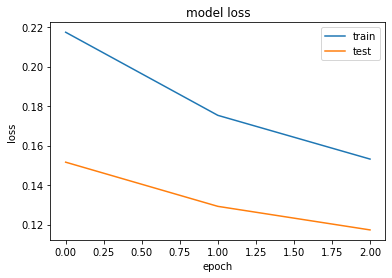

In [30]:
plot_train_history_loss(transfer)

After training, the accuracy of training set is 0.9415, the accuracy of testing set is 0.9553.     
   
Transfer learning has better performance than deep CNN. Transfer learning achieves accuracy on testing set of 0.9553 despite of 3 epochs used. In CNN, the number of epoch is 20 but only to achieve 0.8980 accuracy.



### 3. Text Classification

#### Text Exploration & Cleaning

In [25]:
import pandas as pd
files = open("tweets_with_labels.csv")
lines = files.readlines()
files.close()
lines = [line.strip('\n') for line in lines]
comments = [line.split("\t") for line in lines]
header = comments[0]
print('The header have', len(header), 'features')
print('There are', len(comments), 'records')

The header have 17 features
There are 77947 records


In [26]:
comments = [c for c in comments[1:] if len(c)==17]
print('After removing invalid comments, there are', len(comments), 'left.')

After removing invalid comments, there are 77847 left.


In [27]:
df = pd.DataFrame(columns=header, data=comments)
df.head(n=10)

,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,1,Jazz for a Rainy Afternoon: {link},0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2,RT: @mention: I love rainy days.,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,3,Good Morning Chicago! Time to kick the Windy C...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0,0,0,0,0,0,0.604,0,0.196,0,0,0,0.201,0,0
4,9,@mention good morning sunshine,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,10,Rather be storm chasing.,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6,11,#WEATHER: 1:54 pm : 61.0F. Feels 60F. 29.98% ...,0,0.203,0.176,0,0.376,0,0.421,0,0.176,0,0,0,0,0,0.579
7,13,Father. Son. Holy ghost. Amen... hope I come o...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,14,Mild Monday best weather day of the week in Ok...,0,0,0,0.194,0,0,0.605,0,0.2,0,0,0,0,0,0
9,15,"With the snow forecast for Tahoe this weekend,...",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


I notice the row where id=11, the values over k1 to k15 sum to almost 2. Obviously this is incorrect according to the question.

In [28]:
df.iloc[:,2:]=df.iloc[:,2:].astype('float')

# The label is the fraction of annotations for a given topic, and each row should sum to 1.
valid = [r for r in range(df.shape[0]) if 0.95<=sum(df.iloc[r,2:])<=1.05] 
len(valid)

54587

In [29]:
df = df.loc[valid,:] 

df.head(n=10)

,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,1,Jazz for a Rainy Afternoon: {link},0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2,RT: @mention: I love rainy days.,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,3,Good Morning Chicago! Time to kick the Windy C...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0,0,0,0,0,0,0.604,0,0.196,0,0,0,0.201,0,0
4,9,@mention good morning sunshine,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,10,Rather be storm chasing.,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,13,Father. Son. Holy ghost. Amen... hope I come o...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,14,Mild Monday best weather day of the week in Ok...,0,0,0,0.194,0,0,0.605,0,0.2,0,0,0,0,0,0
9,15,"With the snow forecast for Tahoe this weekend,...",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
13,21,RT @mention: Rainy afternoons are great for ho...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


For each output category, use a sigmoid to collapse the output to between 0 and 1, each category output is independent of the others.

In [31]:
df = df[df.tweet!='']

import math
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

df2=df
for i in df2.columns[2:]:
    df2[i]  = df2[i].apply(lambda m: 1 if round(sigmoid(m)) else 0)
    

df2.head(10)

,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,1,Jazz for a Rainy Afternoon: {link},0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2,RT: @mention: I love rainy days.,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,3,Good Morning Chicago! Time to kick the Windy C...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
4,9,@mention good morning sunshine,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,10,Rather be storm chasing.,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,13,Father. Son. Holy ghost. Amen... hope I come o...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,14,Mild Monday best weather day of the week in Ok...,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0
9,15,"With the snow forecast for Tahoe this weekend,...",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
13,21,RT @mention: Rainy afternoons are great for ho...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


Text(0.5, 0, 'Comment Type ')

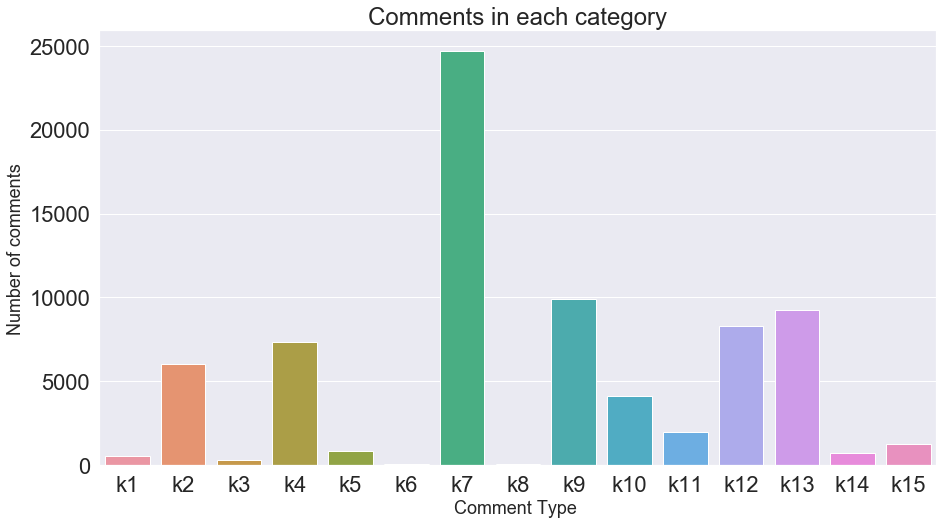

In [32]:
categories = list(df2.columns.values)
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(categories[2:], df2.iloc[:,2:].sum().values)
plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)


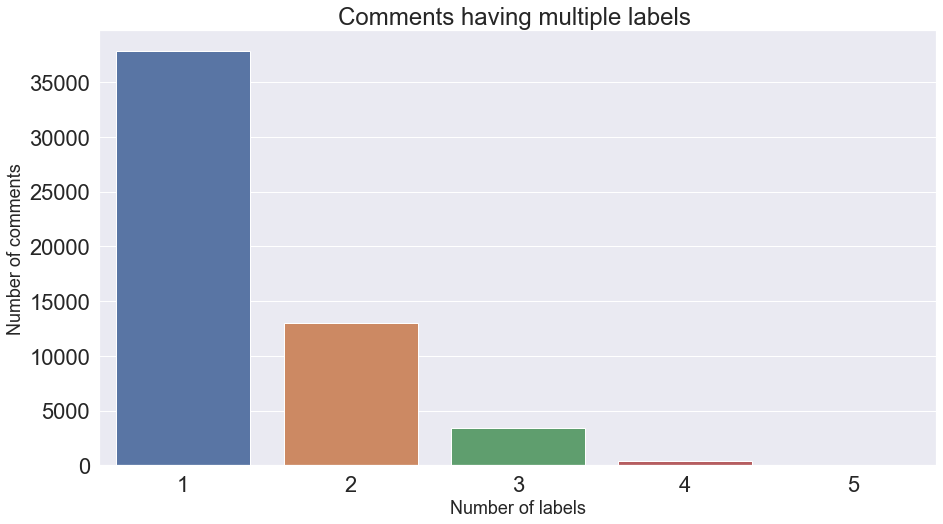

In [33]:
rowSums = df2.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

plt.show()

#### (1) RNN

##### Text Preprocessing

(1) remove punctuations and multiple spaces

In [34]:
# --- Loading text and labels ----
x = df2["tweet"].values
y = df2.iloc[:,2:].values

# process text
# Remove punctuations and numbers
import re
x = np.array(list(map(lambda i: re.sub('[^a-zA-Z]', ' ', i), x)))
x = np.array(list(map(lambda i: re.sub(r'\s+', ' ', i), x)))

(2) tokenization

In [35]:
# tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_NUM_WORDS = 2000 
MAX_SEQUENCE_LENGTH = 100 

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)

# --- Tokenizing the words ---
word_index = tokenizer.word_index
print('Found {w} unique tokens in the texts.'.format(w=len(word_index)))

# --- Padding sequences ---
x = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', x.shape)
print('Shape of label:', y.shape)

Found 33842 unique tokens in the texts.
Shape of data tensor: (54587, 100)
Shape of label: (54587, 15)


In [36]:
x

array([[   0,    0,    0, ...,   45,  239,   11],
       [   0,    0,    0, ...,   68,   45,   89],
       [   0,    0,    0, ...,  406,   98,  440],
       ...,
       [   0,    0,    0, ...,   28, 1606,  568],
       [   0,    0,    0, ...,   23,    2,  258],
       [   0,    0,    0, ...,  508,   17,   11]], dtype=int32)

##### Split dataset

In [39]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)

##### Create model

Our model will have one input layer, one embedding layer, one LSTM layer with 128 neurons and one output layer with 15 neurons since we have 15 labels in the output.


First, use GloVe word embeddings to convert text inputs to their numeric counterparts.

In [37]:
embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    # - First entry is the word -
    word = records[0]
    # - The remaining vectors are strings that need to be converted to floats-
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    # Embeddings is a dictionary of words:word_vector_embeddings
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

print('Found {} word vectors.'.format(len(embedding_matrix)))

Found 33843 word vectors.


In [42]:
# --- Define embedding layer ----

embedding_layer = Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)
deep_inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(deep_inputs)
LSTM_Layer_1 = LSTM(128)(x)
dense_layer_1 = Dense(15, activation='sigmoid')(LSTM_Layer_1)
rnn_model = Model(inputs=deep_inputs, outputs=dense_layer_1)

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [43]:
print(rnn_model.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 100)          3384300   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 15)                1935      
Total params: 3,503,483
Trainable params: 119,183
Non-trainable params: 3,384,300
_________________________________________________________________
None


In [45]:
rnn_history = rnn_model.fit(x_train, y_train, batch_size=256, epochs=10, validation_data=(x_test, y_test))

Train on 43669 samples, validate on 10918 samples
Epoch 1/10
43669/43669 [==============================] - 86s 2ms/step - loss: 0.1928 - acc: 0.9291 - val_loss: 0.1422 - val_acc: 0.9499
Epoch 2/10
43669/43669 [==============================] - 74s 2ms/step - loss: 0.1239 - acc: 0.9575 - val_loss: 0.1102 - val_acc: 0.9616
Epoch 3/10
43669/43669 [==============================] - 88s 2ms/step - loss: 0.1071 - acc: 0.9623 - val_loss: 0.1008 - val_acc: 0.9649
Epoch 4/10
43669/43669 [==============================] - 81s 2ms/step - loss: 0.1001 - acc: 0.9650 - val_loss: 0.0967 - val_acc: 0.9665
Epoch 5/10
43669/43669 [==============================] - 84s 2ms/step - loss: 0.0972 - acc: 0.9659 - val_loss: 0.0951 - val_acc: 0.9668
Epoch 6/10
43669/43669 [==============================] - 90s 2ms/step - loss: 0.0952 - acc: 0.9664 - val_loss: 0.0940 - val_acc: 0.9673
Epoch 7/10
43669/43669 [==============================] - 73s 2ms/step - loss: 0.0937 - acc: 0.9668 - val_loss: 0.0926 - val_acc

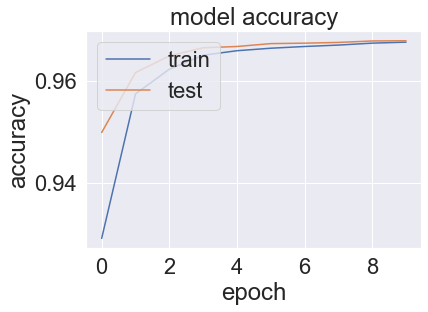

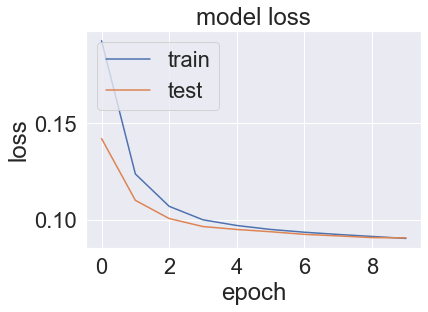

In [46]:
import matplotlib.pyplot as plt

plt.plot(rnn_history.history['acc'])
plt.plot(rnn_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(rnn_history.history['loss'])
plt.plot(rnn_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

The accuracy on training set is 0.9676, the accuracy on testing set is 0.9679.

#### (2) 1D CNN with character-level convolution

##### Text preprocessing    
(1) remove multiple spaces and convert string to lower case

In [78]:
# --- Loading text and labels ----
x = df2["tweet"].values
y = df2.iloc[:,2:].values

# process text
# Remove extra spaces
import re
x = np.array(list(map(lambda i: re.sub(r'\s+', ' ', i), x)))

# convert string to lower case
x = [s.lower() for s in x]

(2) Tokenization

In [80]:
# =======================Convert string to index================
# Tokenizer
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tk.fit_on_texts(x)

# construct a new vocabulary
alphabet = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
char_dict = {}
for i, char in enumerate(alphabet):
    char_dict[char] = i + 1

# Use char_dict to replace the tk.word_index
tk.word_index = char_dict.copy()
# Add 'UNK' to the vocabulary
tk.word_index[tk.oov_token] = max(char_dict.values()) + 1

# Convert string to index 
sequences = tk.texts_to_sequences(x)  # train_sequence改的

# Padding
maxlen = 1014
data = pad_sequences(sequences, maxlen=maxlen, padding='post')

# Convert to numpy array
data = np.array(data, dtype='float32')

print(data.shape)

(54587, 1014)


##### Split data

In [81]:
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.20, random_state=1)

##### Create model

Load Embedding Weights

In [82]:
vocab_size = len(tk.word_index)
print(vocab_size)

69


Then we use the one-hot vector to represent these 69 words, which means each character has 69 dimensions. Because Keras use 0 for PAD, we add a zero vector to represent PAD.

In [83]:
# Embedding weights
embedding_size = 69
embedding_weights = []  # (70, 69)
embedding_weights.append(np.zeros(vocab_size))  # (0, 69)

for char, i in tk.word_index.items():  # from index 1 to 69
    onehot = np.zeros(vocab_size)
    onehot[i - 1] = 1
    embedding_weights.append(onehot)

embedding_weights = np.array(embedding_weights)
print('Load')

# Embedding layer Initialization
embedding_layer = Embedding(vocab_size + 1,
                            embedding_size,
                            input_length=maxlen,
                            weights=[embedding_weights], trainable=False)


Load


In [84]:
# Model Construction
# Input
cnn_inputs = Input(shape=(maxlen,), name='input', dtype='int64')  # shape=(?, 1014)
x = embedding_layer(cnn_inputs)
x = Dropout(0.3)(x)
x = Conv1D(32, 3, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D()(x)
x = Conv1D(32, 3, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D()(x)
x = Flatten()(x)
x = Dense(200, activation="relu")(x)
x = Dropout(0.3)(x)

predictions = Dense(15, activation='sigmoid')(x)
cnn_model = Model(inputs=cnn_inputs, outputs=predictions)
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc']) # Adam, categorical_crossentropy
cnn_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1014)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1014, 69)          4830      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1014, 69)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1012, 32)          6656      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 506, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 504, 32)           3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 252, 32)           0   

In [86]:
history_cnn = cnn_model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

Train on 43669 samples, validate on 10918 samples
Epoch 1/10
43669/43669 [==============================] - 84s 2ms/step - loss: 0.1843 - acc: 0.9348 - val_loss: 0.1567 - val_acc: 0.9468
Epoch 2/10
43669/43669 [==============================] - 75s 2ms/step - loss: 0.1649 - acc: 0.9424 - val_loss: 0.1368 - val_acc: 0.9545
Epoch 3/10
43669/43669 [==============================] - 78s 2ms/step - loss: 0.1510 - acc: 0.9476 - val_loss: 0.1242 - val_acc: 0.9572
Epoch 4/10
43669/43669 [==============================] - 70s 2ms/step - loss: 0.1428 - acc: 0.9505 - val_loss: 0.1183 - val_acc: 0.9595
Epoch 5/10
43669/43669 [==============================] - 78s 2ms/step - loss: 0.1378 - acc: 0.9525 - val_loss: 0.1140 - val_acc: 0.9610
Epoch 6/10
43669/43669 [==============================] - 78s 2ms/step - loss: 0.1337 - acc: 0.9537 - val_loss: 0.1111 - val_acc: 0.9619
Epoch 7/10
43669/43669 [==============================] - 77s 2ms/step - loss: 0.1307 - acc: 0.9546 - val_loss: 0.1090 - val_acc

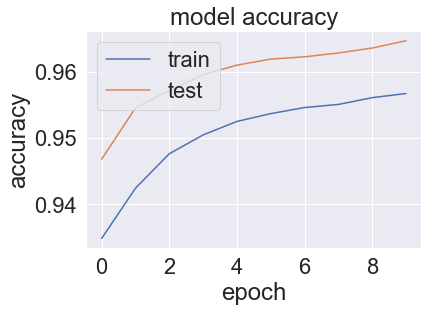

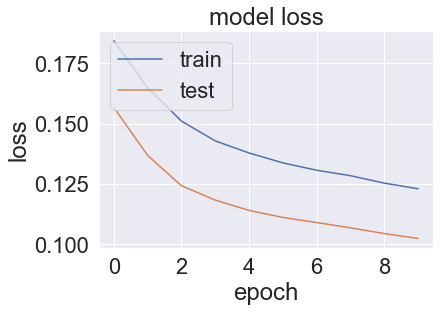

In [87]:
import matplotlib.pyplot as plt

plt.plot(history_cnn.history['acc'])
plt.plot(history_cnn.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

The accuracy on training set is 0.9567, the accuracy on testing set is 0.9647.

#### (3) ROC Curve for Comparison

In [72]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
rnn_model_y_pred = rnn_model.predict(x_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(15):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], rnn_model_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), rnn_model_y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

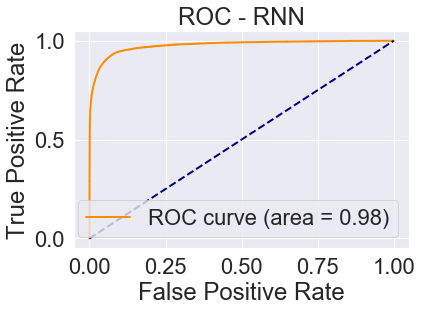

In [77]:
plt.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc["micro"]) 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - RNN')
plt.legend(loc="lower right")
plt.show()

In [88]:
# Compute ROC curve and ROC area for each class
cnn_model_y_pred = cnn_model.predict(x_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(15):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], cnn_model_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), cnn_model_y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


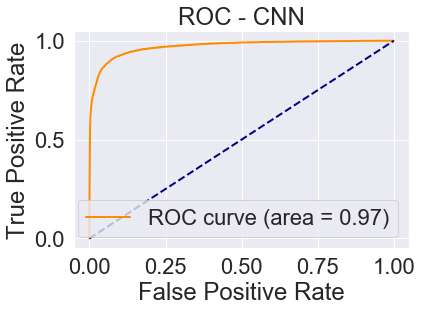

In [89]:
plt.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc["micro"]) 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - CNN')
plt.legend(loc="lower right")
plt.show()

AUC value on test set using RNN(LSTM) is 0.98, while AUC value on test set using CNN is 0.97. Both have good performance while LSTM is slightly better.